In [10]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import scanpy.external as scex
import sklearn.metrics
import seaborn as sns
from matplotlib import pyplot as plt


In [11]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [12]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.12


In [13]:
%matplotlib inline

In [14]:
writeDir = "write/"

fileName = "luadMDA"

resultsFile = writeDir + fileName + '.h5ad'       # final output
resultsFileQC = f"{writeDir}{fileName}_QC.h5ad"  # post QC (pre-analysis) 

In [15]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/"
figName = fileName

In [8]:
adata = sc.read(resultsFileQC)
adata

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 245091 × 26381
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [9]:
adata.obs["patient"]=[name.split("_")[0].split("-")[0] for name in adata.obs_names.values]

In [10]:
#kras = ["P10T","P14T","P2"]
#adata = adata[[p in kras for p in adata.obs.patient],]
adata = adata[adata.obs.celltype=="malig"]
#adata.write('write/luadMDAkras_QC.h5ad')

In [11]:
sc.pp.normalize_total(adata,target_sum=1e4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [12]:
sc.pp.log1p(adata)

In [13]:
sc.pp.highly_variable_genes(adata)#, flavor = "seurat", n_top_genes=2000)

extracting highly variable genes


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


2537


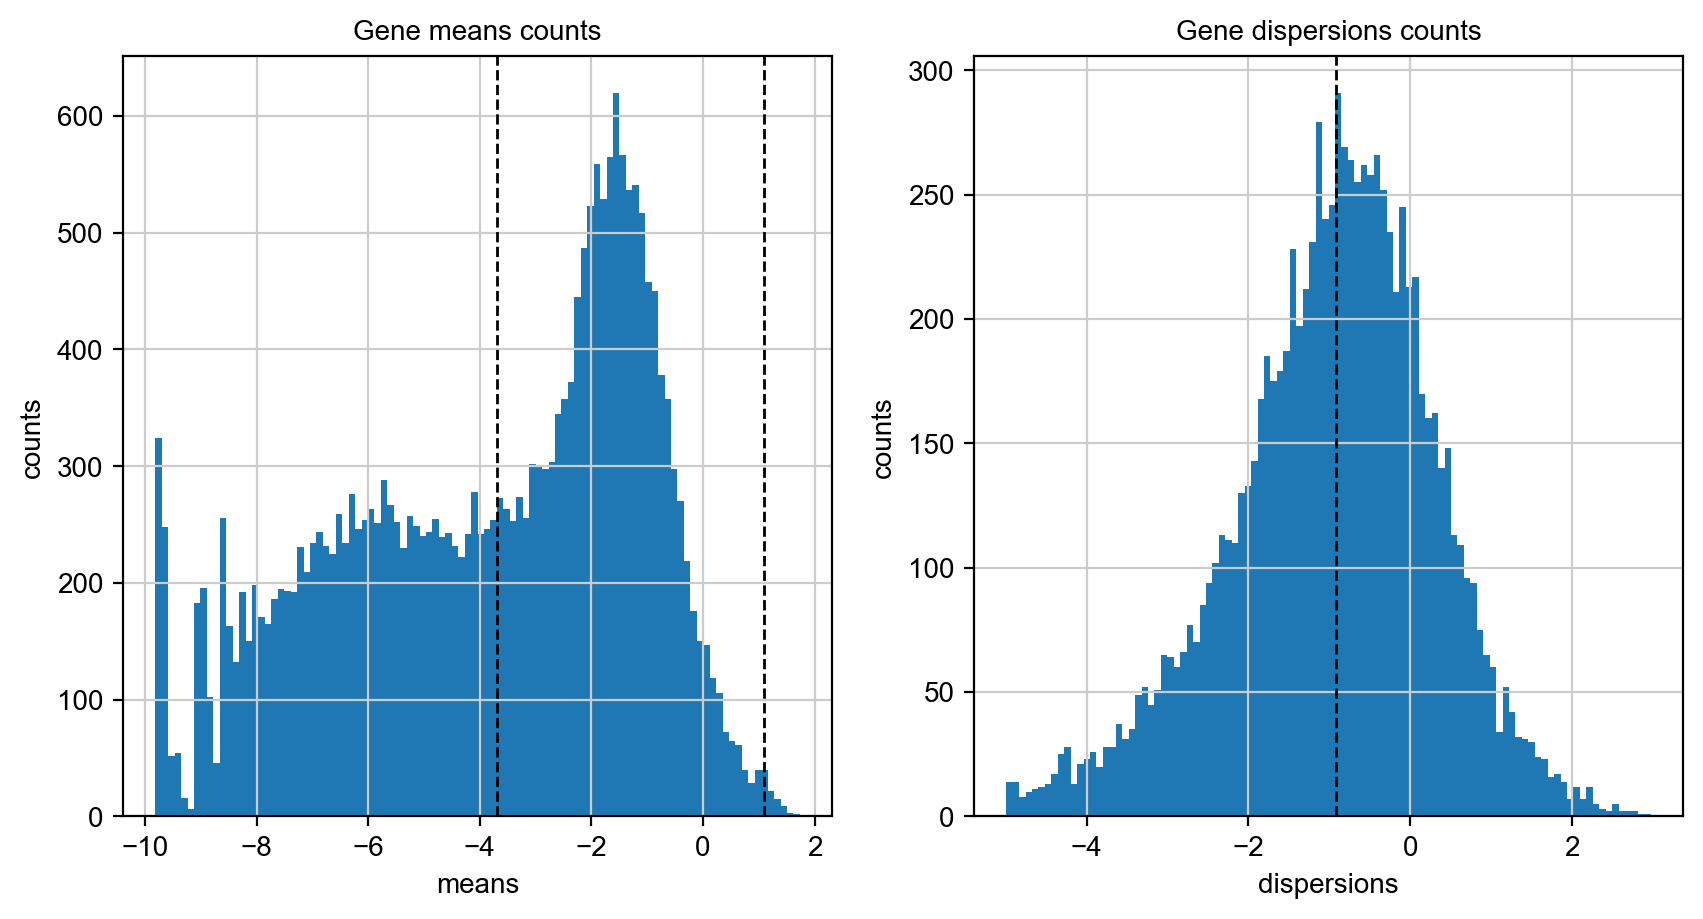

In [14]:
minMean = 0.025
maxMean = 3
minDisp = 0.4

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-5)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean)
print(sum(adata.var.highly_variable))

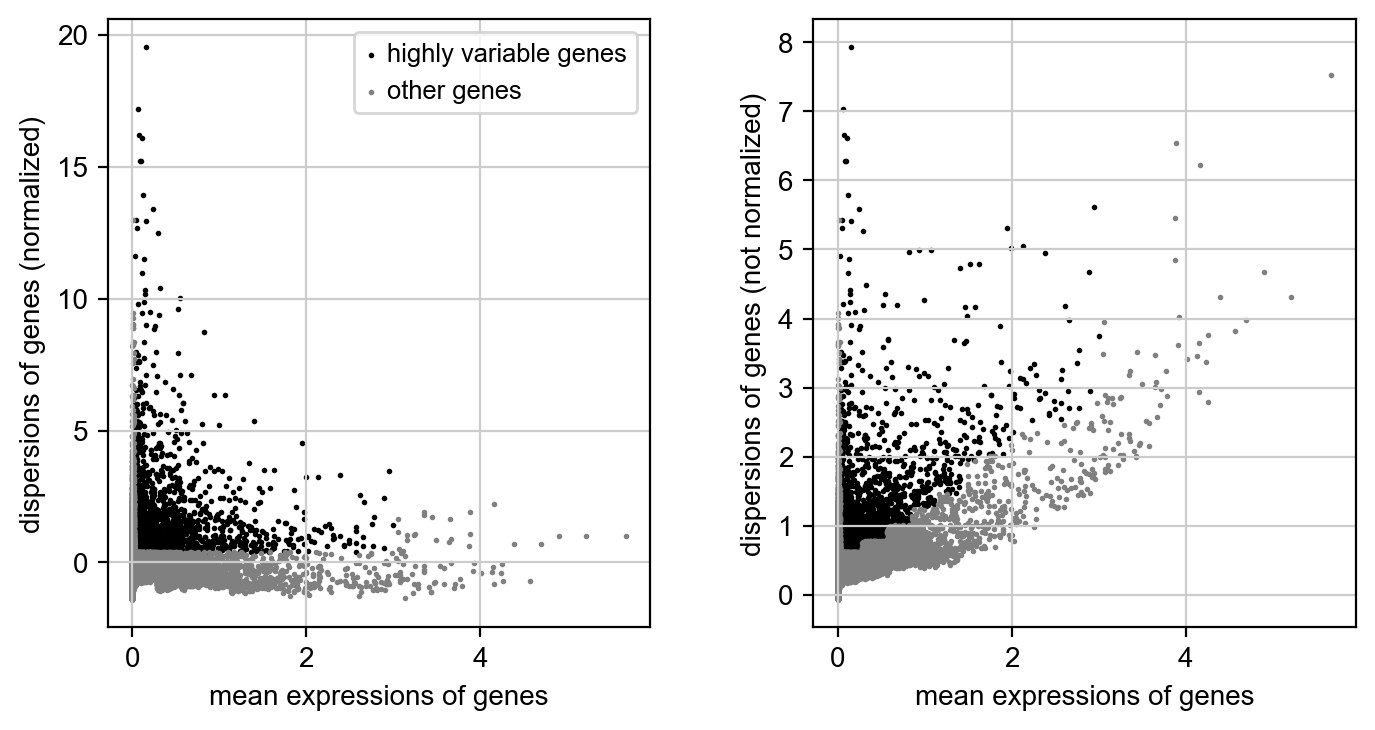

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
#for inGene in adata.var[-8:].index.tolist():
#    adata.var.loc[inGene,"highly_variable"] = False

In [17]:
adata.raw = adata

In [18]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [19]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [20]:
#sc.pp.scale(adata, max_value=10)

In [21]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:04)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


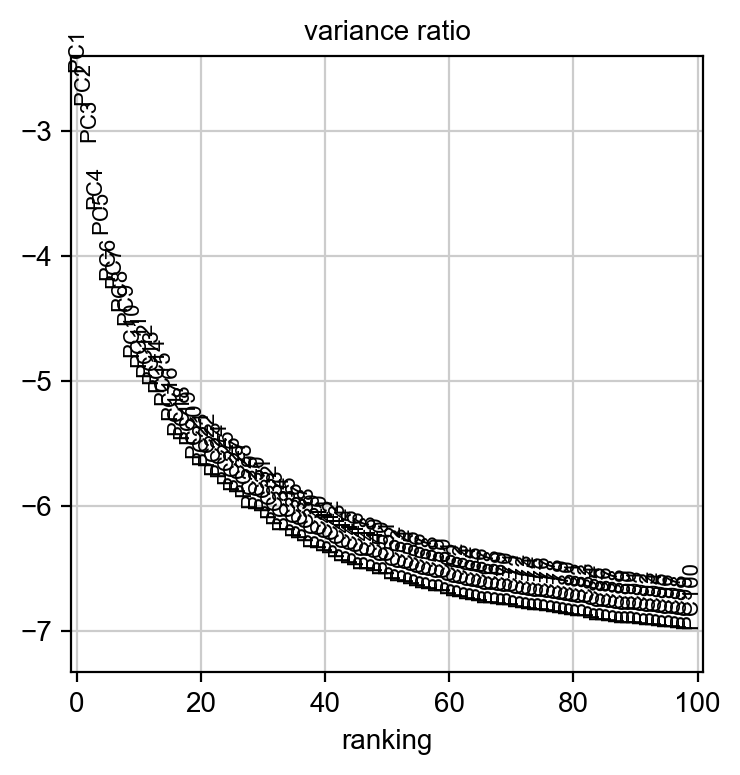

In [22]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

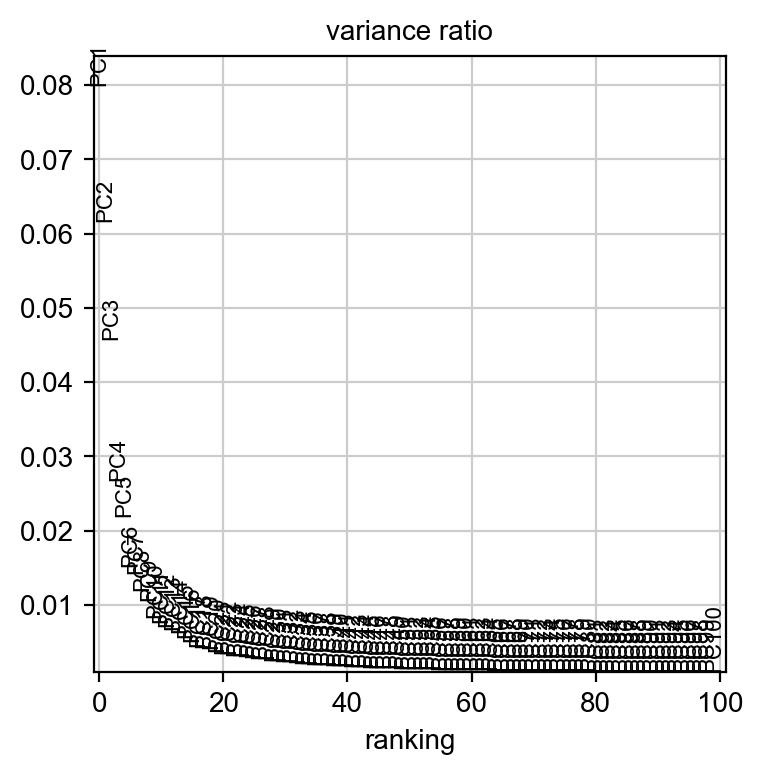

In [23]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

In [24]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [25]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [26]:
sc.tl.leiden(adata, resolution=0.9)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

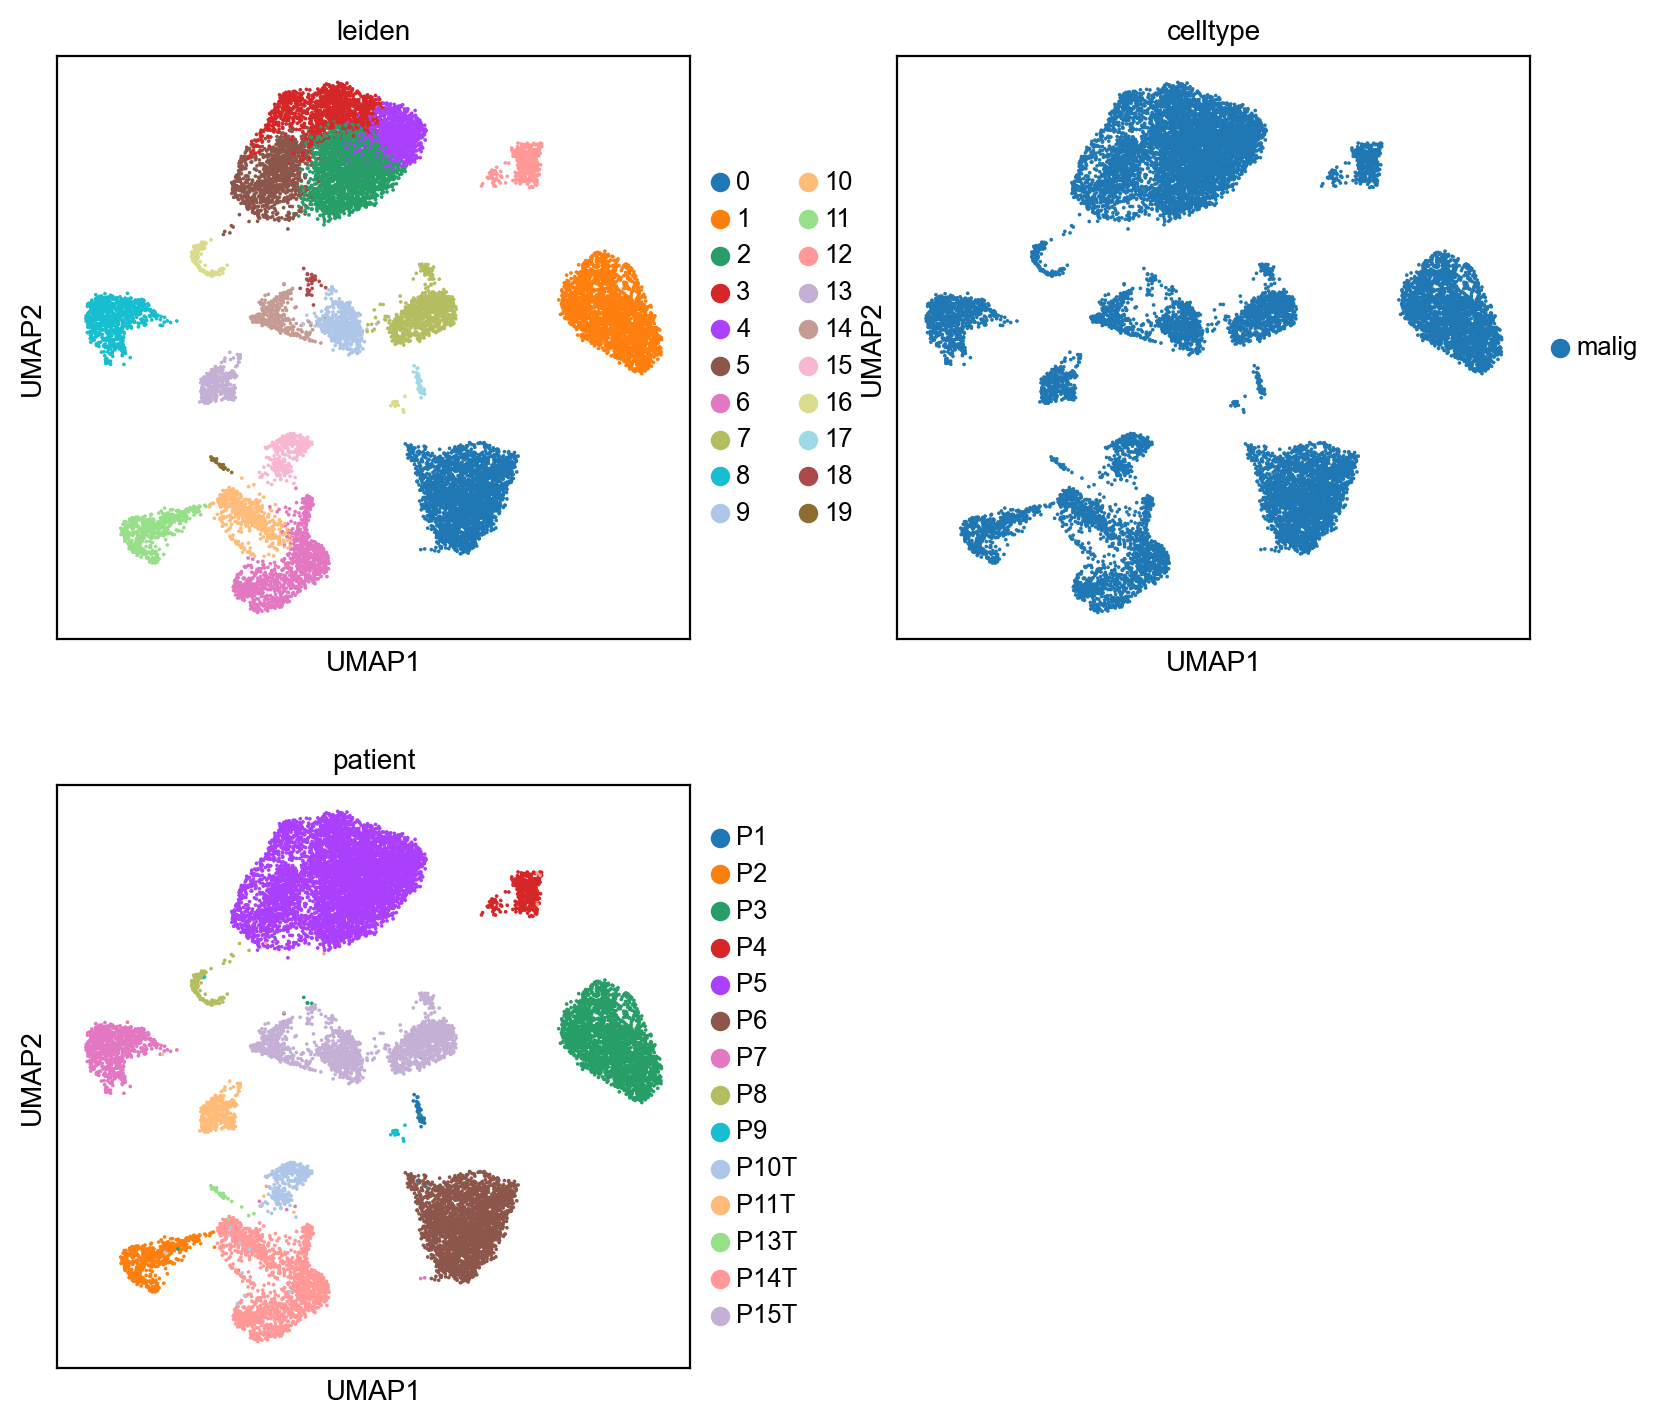

In [27]:
sc.pl.umap(adata, color=["leiden","celltype","patient"],ncols=2)

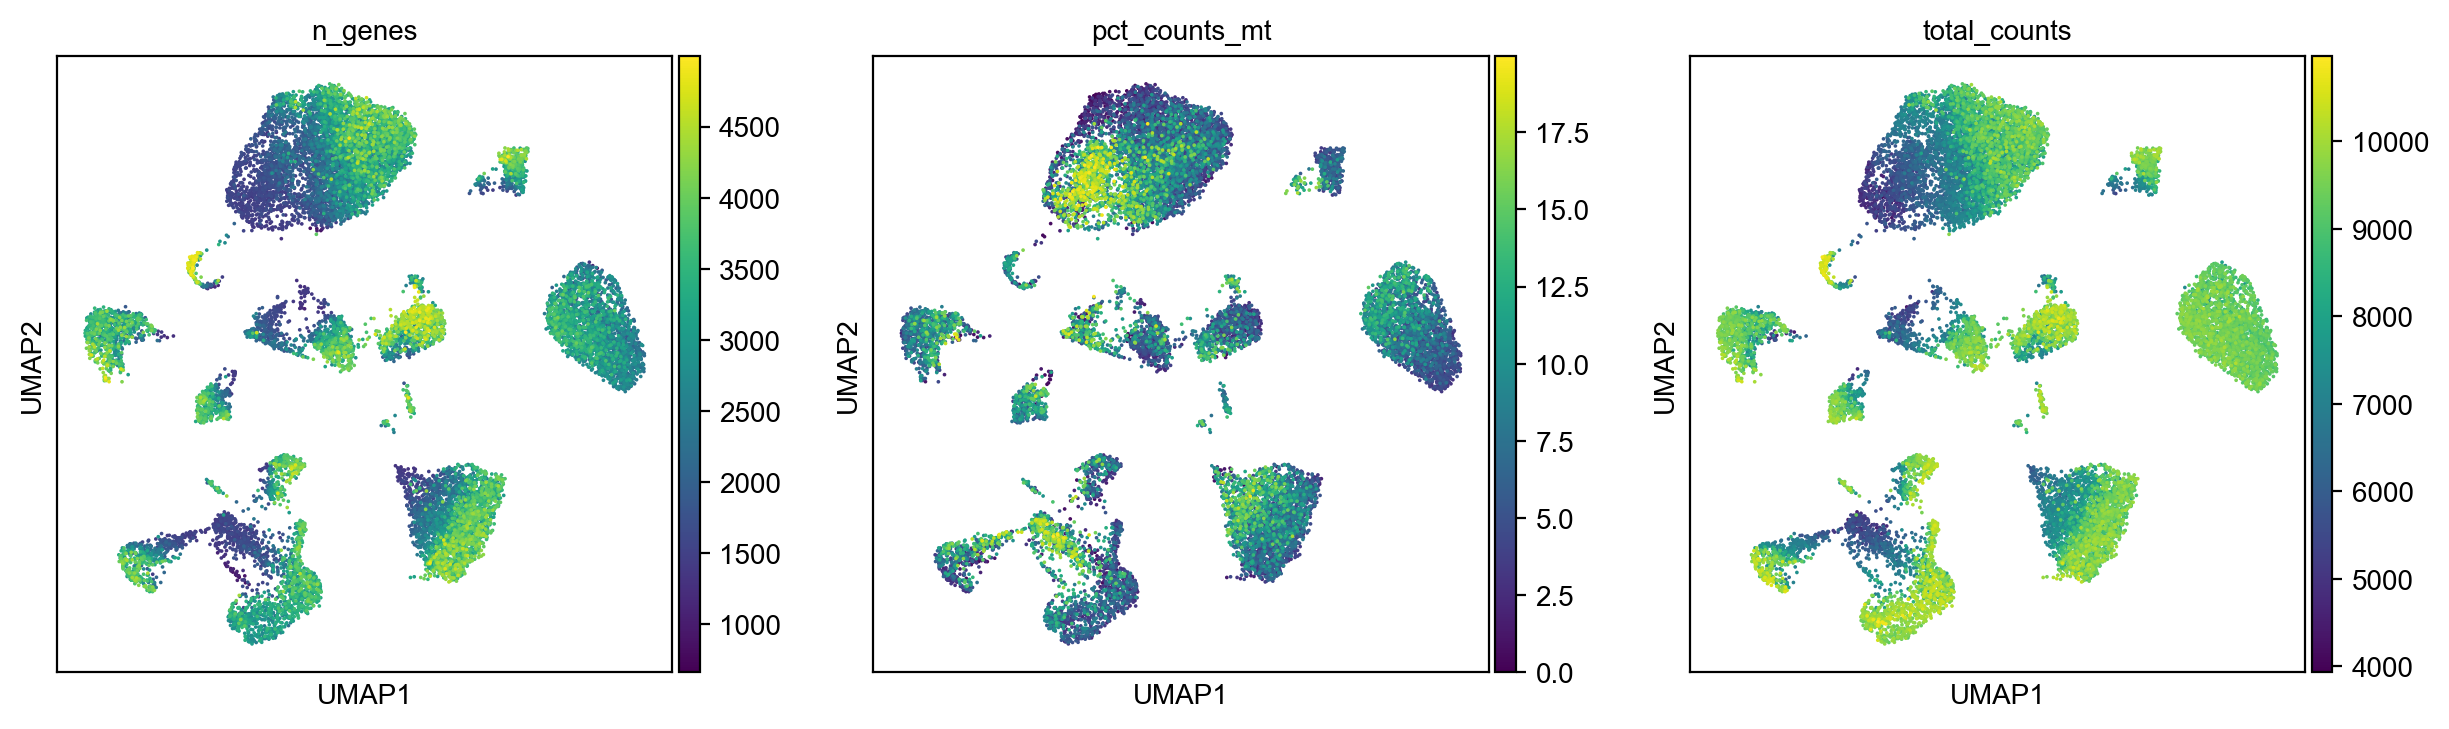

In [28]:
sc.pl.umap(adata, color=["n_genes","pct_counts_mt","total_counts"])

In [29]:
resultsFile

'write/luadMDA.h5ad'

In [191]:
adata.write('write/luadMDAkras.h5ad')
adata

AnnData object with n_obs × n_vars = 2461 × 2995
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'patient', 'leiden', 'At2-likeScore', 'At1-likeScore', 'HPCSScore', 'Endoderm-likeScore', 'AdvScore', 'cellState', 'zsig'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'umap', 'cellState_colors', 'zsig_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [36]:
#adata.write('write/luadMDA_all.h5ad')
adata

AnnData object with n_obs × n_vars = 245091 × 1886
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'patient'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'celltype_colors', 'patient_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
adata = sc.read_h5ad(resultsFileQC)
adata

AnnData object with n_obs × n_vars = 245091 × 26381
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [41]:
adata.obs["patient"]=[name.split("_")[0] for name in adata.obs_names.values]

In [44]:
adata = adata[adata.obs.celltype=="malig"]

In [45]:
sc.pp.normalize_total(adata,target_sum=1e4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [46]:
sc.pp.log1p(adata)

In [47]:
sc.pp.highly_variable_genes(adata)#, flavor = "seurat", n_top_genes=2000)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


2140


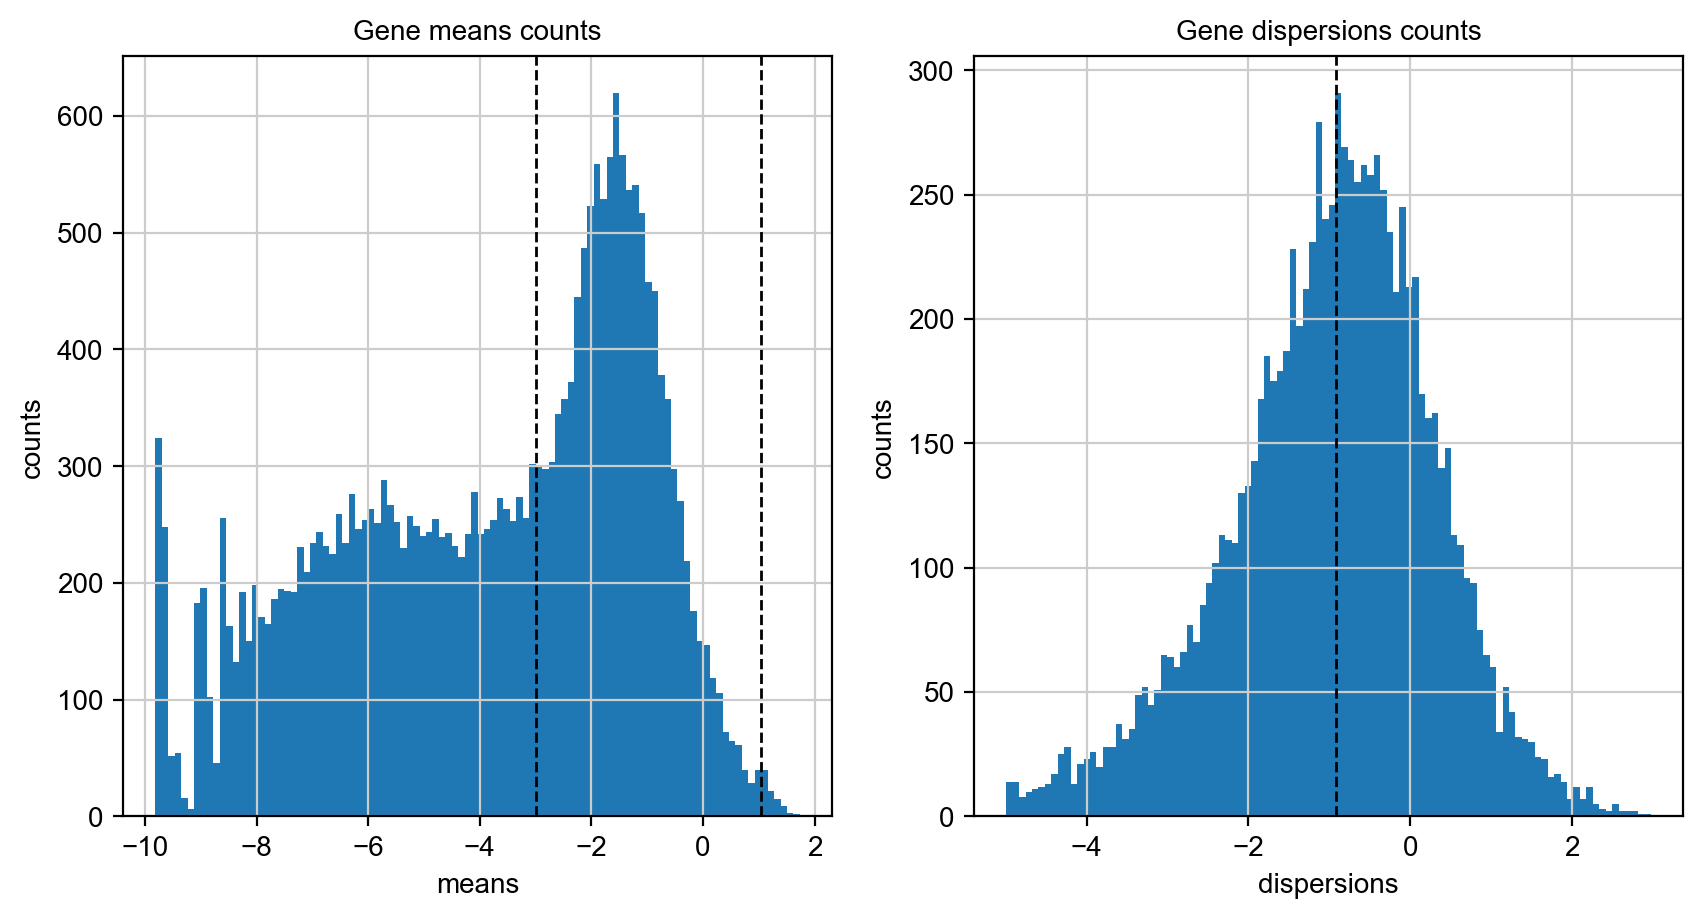

In [50]:
minMean = 0.05
maxMean = 2.8
minDisp = 0.4

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-5)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean)
print(sum(adata.var.highly_variable))

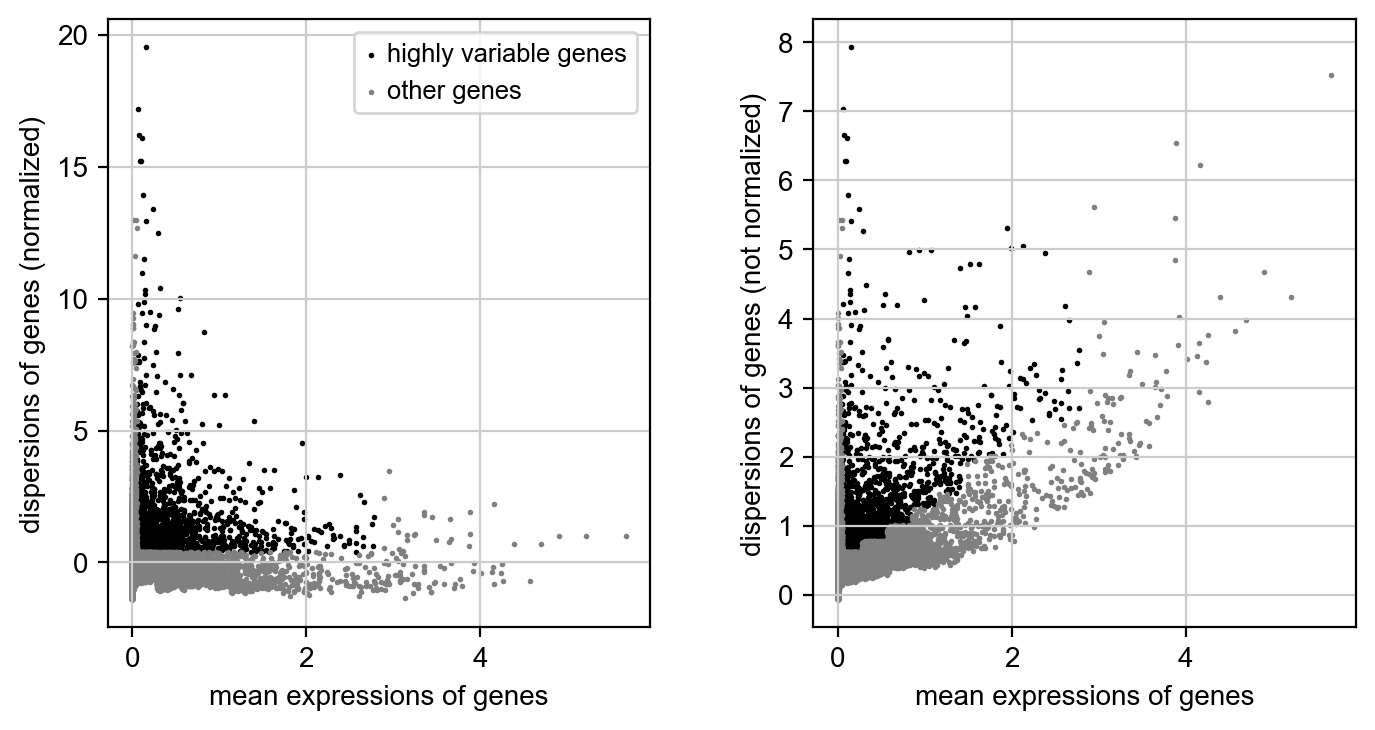

In [51]:
sc.pl.highly_variable_genes(adata)

In [52]:
#for inGene in adata.var[-8:].index.tolist():
#    adata.var.loc[inGene,"highly_variable"] = False

In [53]:
adata.raw = adata

In [54]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [55]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [56]:
#sc.pp.scale(adata, max_value=10)

In [57]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:03)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


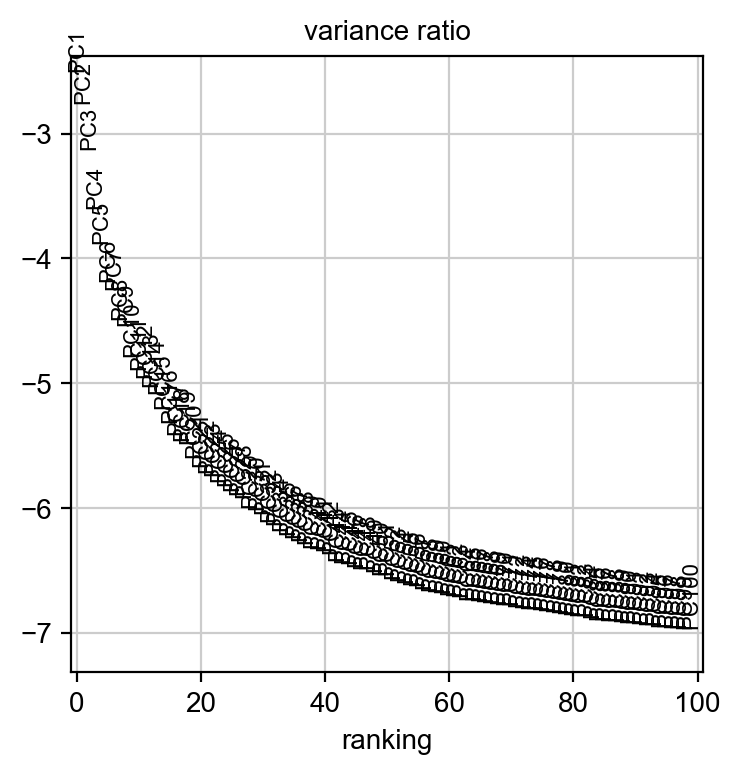

In [58]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

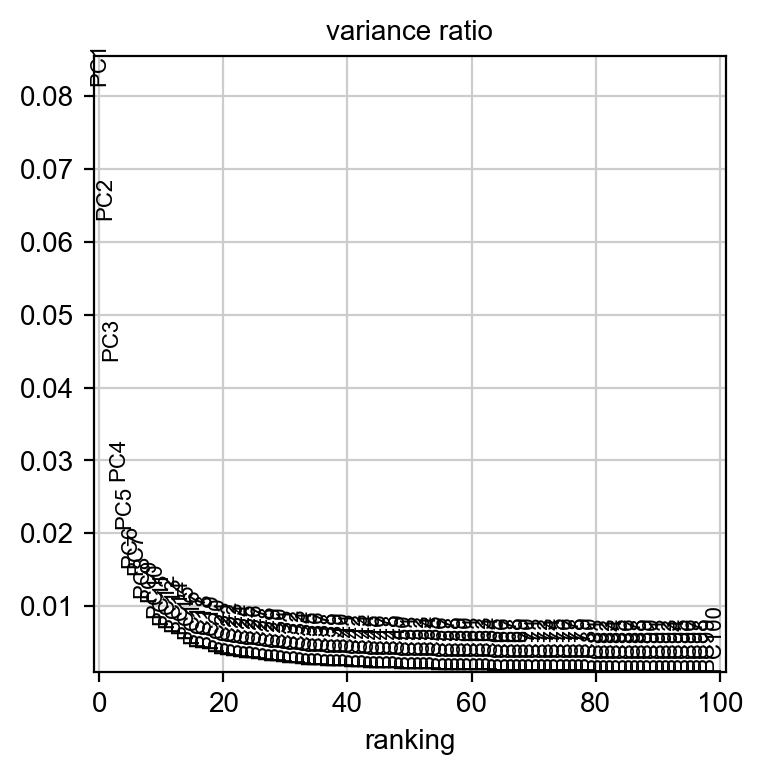

In [59]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

In [60]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [61]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [62]:
sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

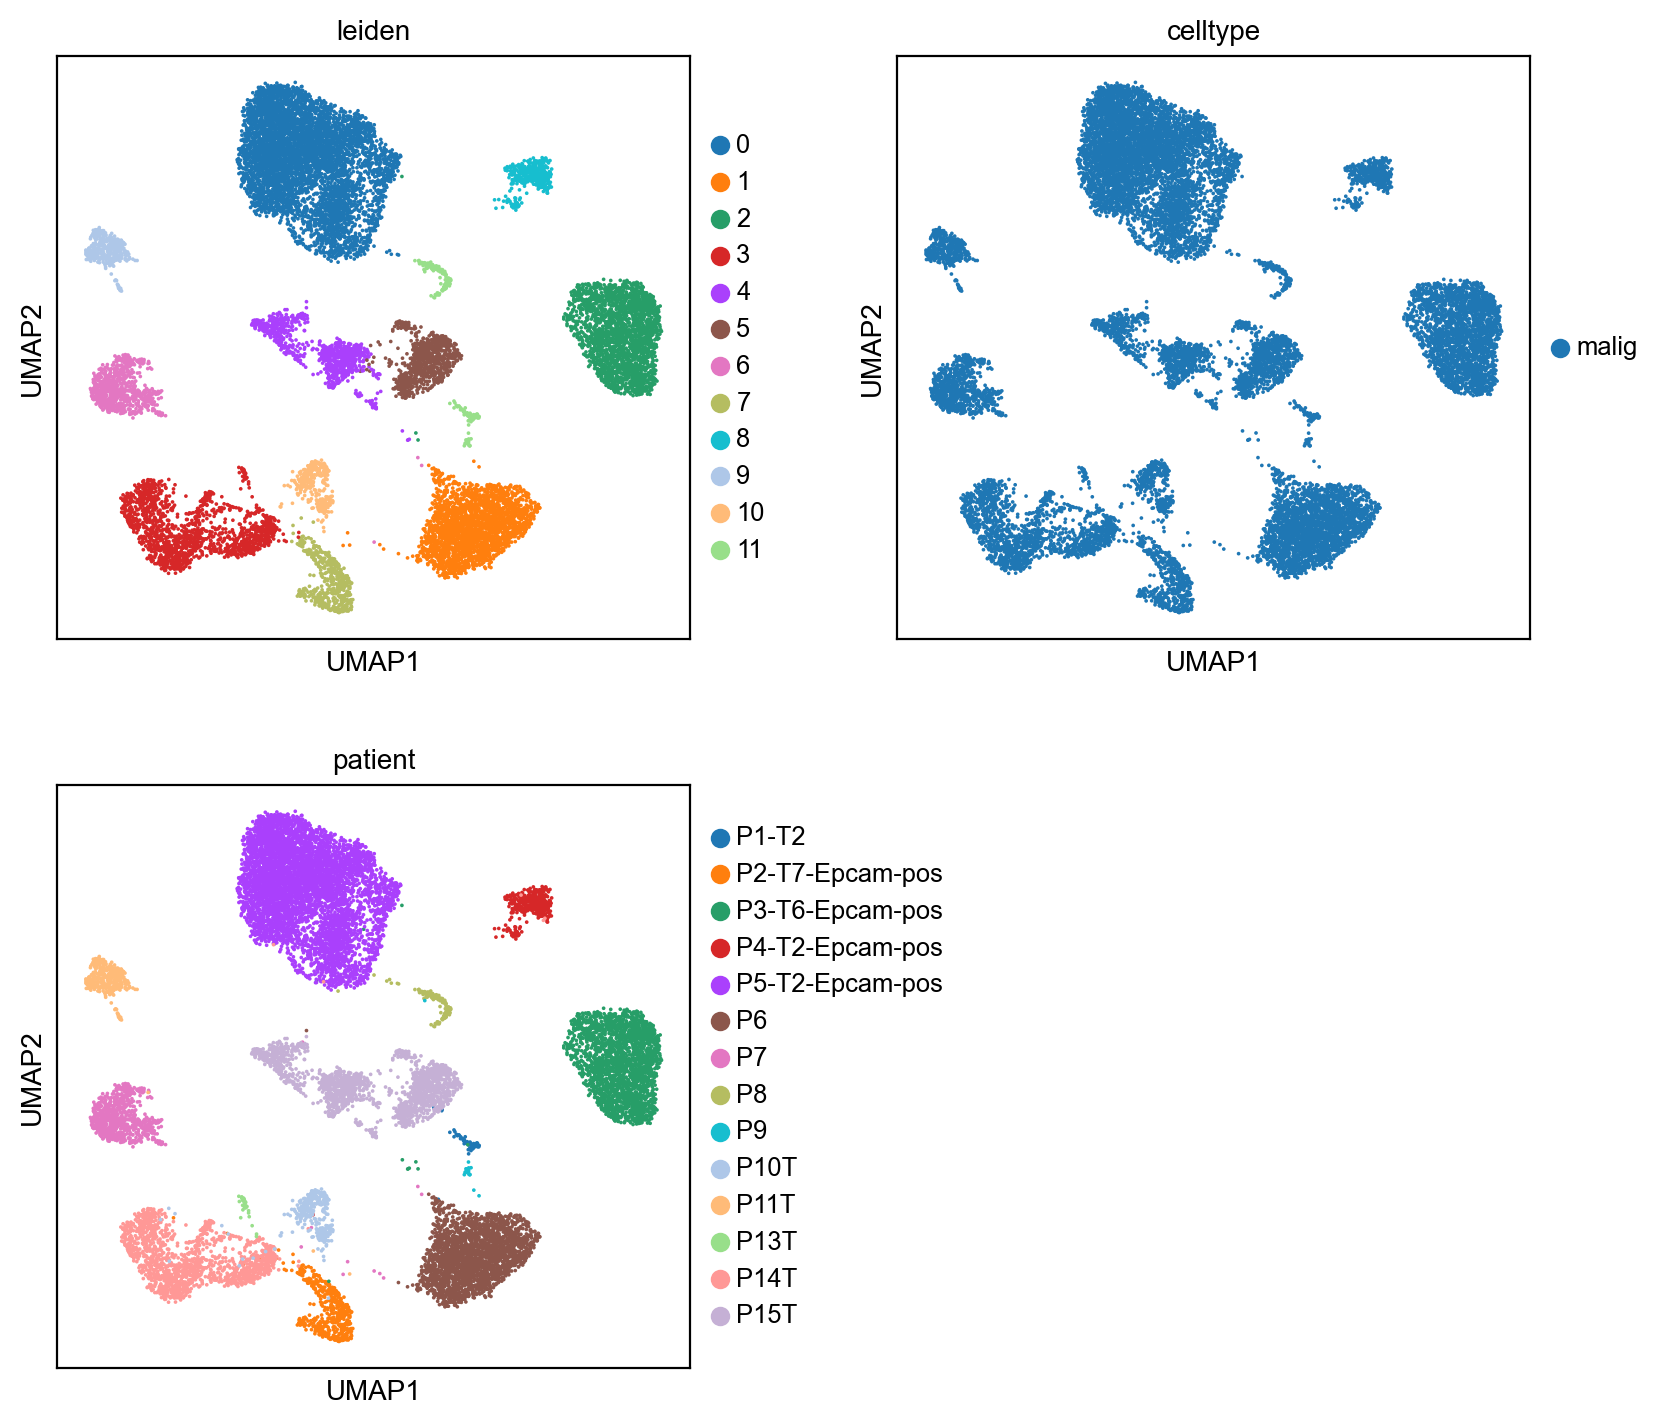

In [67]:
sc.pl.umap(adata, color=["leiden","celltype","patient"],ncols=2)

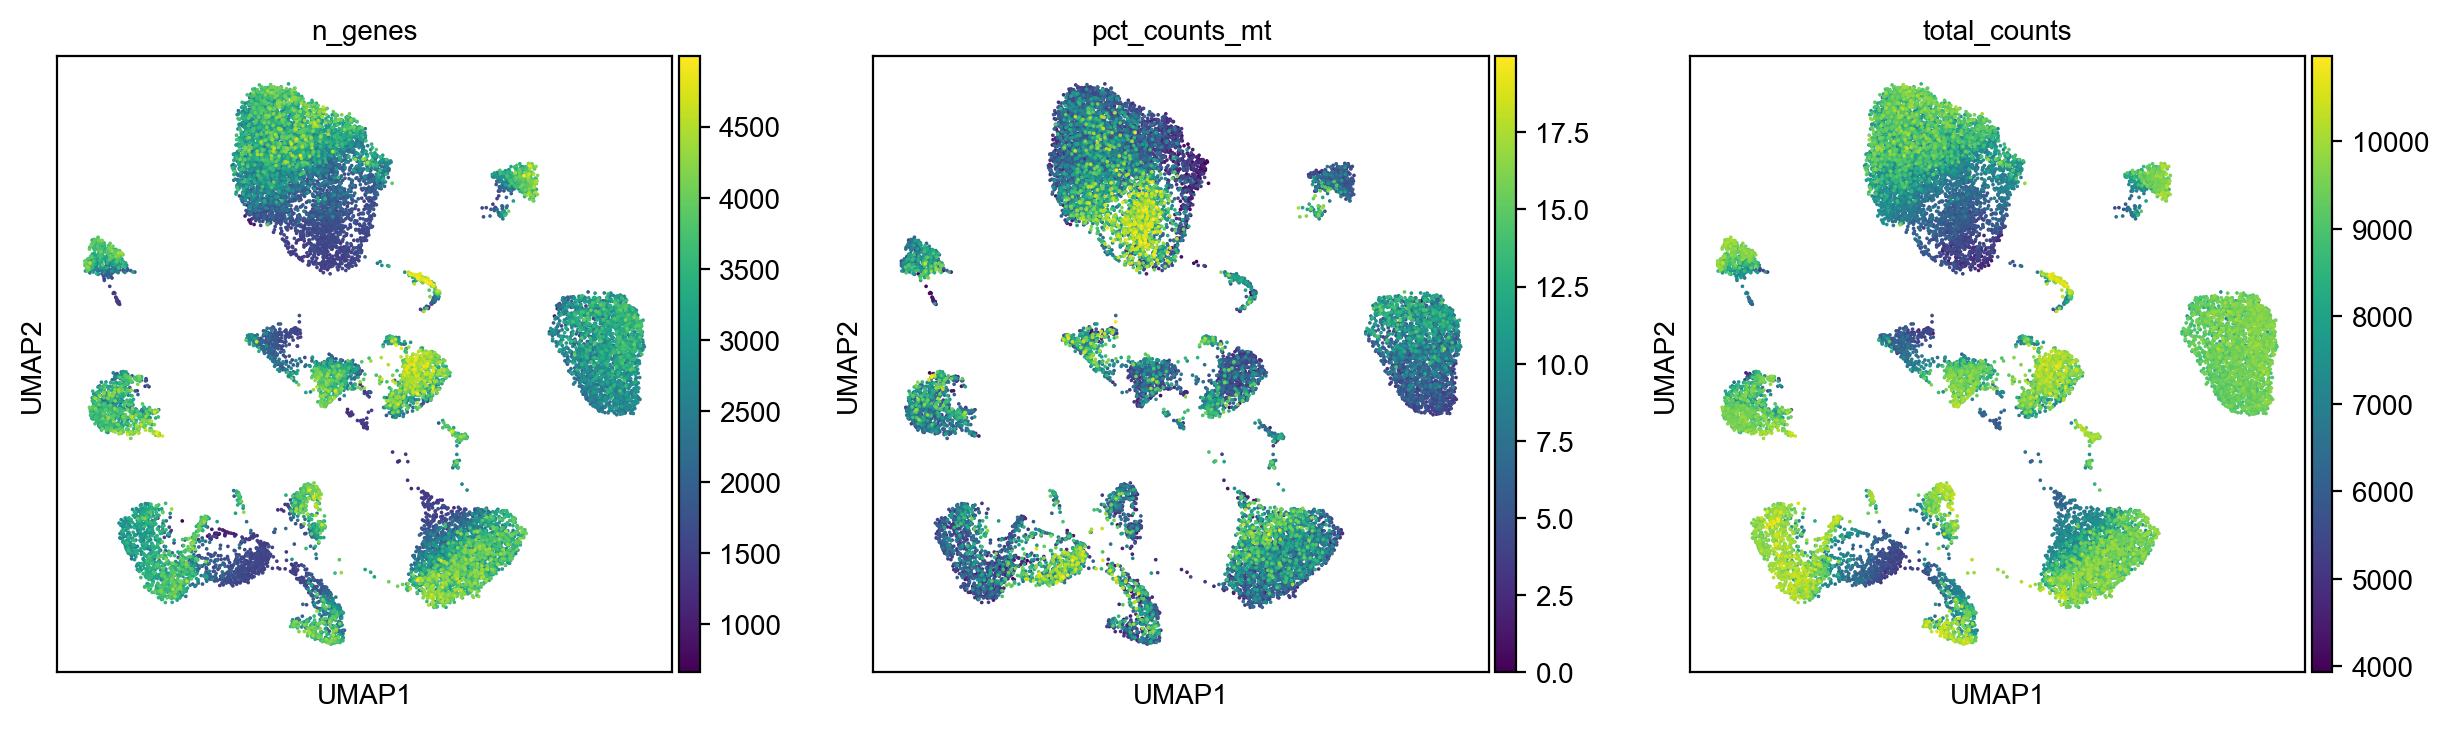

In [64]:
sc.pl.umap(adata, color=["n_genes","pct_counts_mt","total_counts"])

In [65]:
resultsFile

'write/luadMDA.h5ad'

In [68]:
adata.write(resultsFile)

In [17]:
adata = sc.read_h5ad(resultsFile)

In [21]:
hpcs = pd.read_csv("geneSigs/simpLUADcs.csv")["HPCS"]
hpcs

0      SLC4A11
1        IL23A
2         RRAD
3          TNF
4        ABTB2
        ...   
245       FZD5
246       POGK
247     SLC3A2
248     UBE2D3
249      FOSL2
Name: HPCS, Length: 250, dtype: object

In [22]:
kac = pd.read_csv("geneSigs/LUAD/KAC.csv",skiprows=1)["gene"][:250]
kac

0         GAPDH
1        IGFBP3
2          AGR2
3         TIMP1
4           MDK
         ...   
245        EDN1
246       ALDOA
247    C12orf75
248        RHOB
249       DHRS7
Name: gene, Length: 250, dtype: object

In [23]:
kac[209]

'44815'

In [29]:
from scipy.stats import gaussian_kde

def plotScatter(df, xLabel, yLabel, name, save=False):
    xVal, yVal = adata.obs[xLabel].values, adata.obs[yLabel].values
    m, b, r_value, p_value, std_err = stats.linregress(xVal, yVal)

    # Calculate the point density
    xy = np.vstack([xVal,yVal])
    densityColor = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = densityColor.argsort()
    xVal, yVal, densityColor = xVal[idx], yVal[idx], densityColor[idx]
    
    fig, ax = plt.subplots()
    ax.grid(False)
    ax_ = ax.scatter(xVal,yVal, c=densityColor,s=10)
    ax.plot(xVal, m*xVal + b, c="red")
    ax.annotate(f"r^2: {r_value**2:.2f}", xy=(-0.05,np.max(yVal)*0.95))
    ax.annotate(f"pVal: {p_value:.2f}", xy=(-0.05,np.max(yVal)*0.9))

    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title(name)
    plt.colorbar(ax_)
    plt.show()
    if(save):
        fig.savefig(f"figures/{save}/{name}_{xLabel}{yLabel}_scatter.svg")

In [30]:
def plotBoxPlot(dataDF, label, geneExp, gene, name, save=False):
    slcPos = adata.obs[label].values[geneExp]
    slcNeg = adata.obs[label].values[np.logical_not(geneExp)]

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.grid(False)
    # Create box plots
    box1 = ax.violinplot(slcPos, positions=[1], showmeans=True, widths=0.6)
    box2 = ax.violinplot(slcNeg, positions=[2], showmeans=True, widths=0.6)
    
    # Perform a t-test to get the p-value
    t_stat, p_val = stats.ttest_ind(slcPos, slcNeg)
    
    # Add p-value bracket and stars to the plot
    x1, x2 = 1, 2
    y, h, col = max(np.max(slcPos), np.max(slcNeg)), 0.1, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h-0.1, f'{p_val:.3e}', ha='center', va='bottom', color=col)
    
    # Add stars based on p-value significance
    if p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        stars = 'ns'  # not significant
    
    ax.text((x1+x2)*.5, y+h, stars, ha='center', va='bottom', color=col)
    
    # Add p-value text to the plot
    #plt.text(1.5, max(np.max(slcPos), np.max(slcNeg)), f'p-value: {p_val:.3e}', ha='center')
    
    # Set x-axis labels
    ax.set_xticks([1, 2])
    ax.set_xticklabels([f'{gene}+', f'{gene}-'])
    
    # Set title and labels
    ax.set_title(name)
    ax.set_ylabel(f'{label} Score')
    
    # Show the plot
    plt.show()
    if(save):
        fig.savefig(f"figures/{save}/{name}{label}_{gene}.svg")
    

In [31]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = 'Arial'

computing score 'HPCS'
    finished: added
    'HPCS', score of gene set (adata.obs).
    989 total control genes are used. (0:00:00)
computing score 'KAC'
    finished: added
    'KAC', score of gene set (adata.obs).
    591 total control genes are used. (0:00:00)


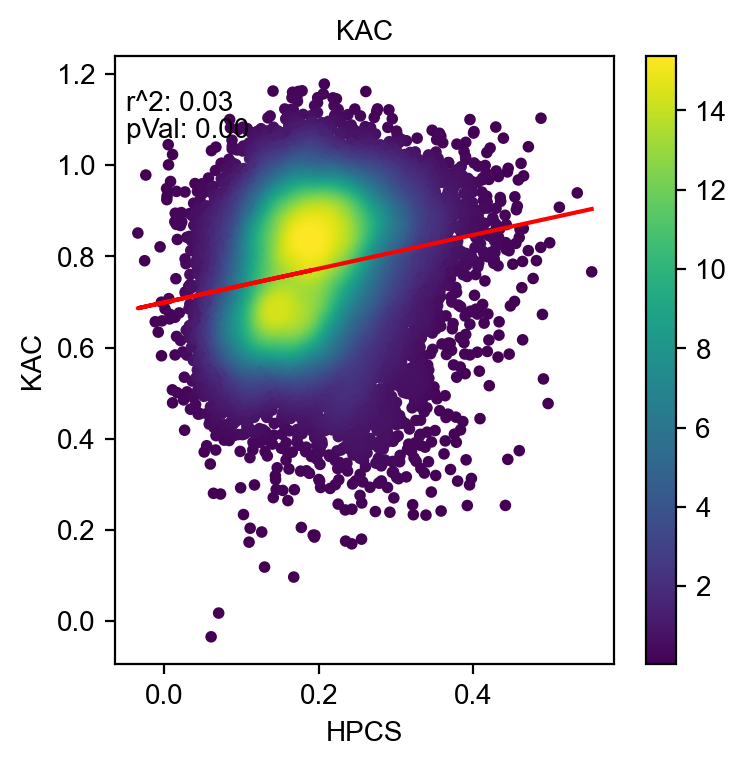

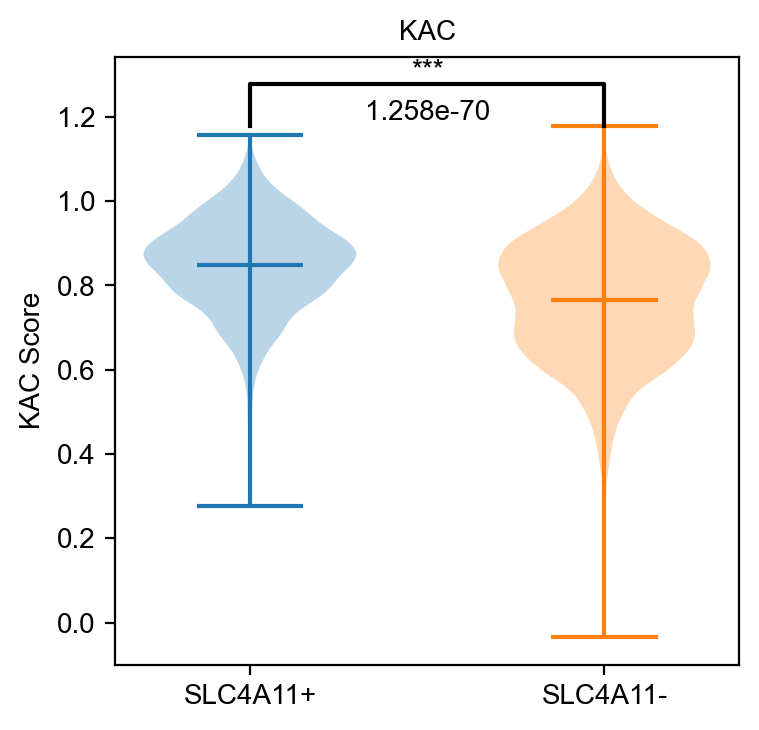

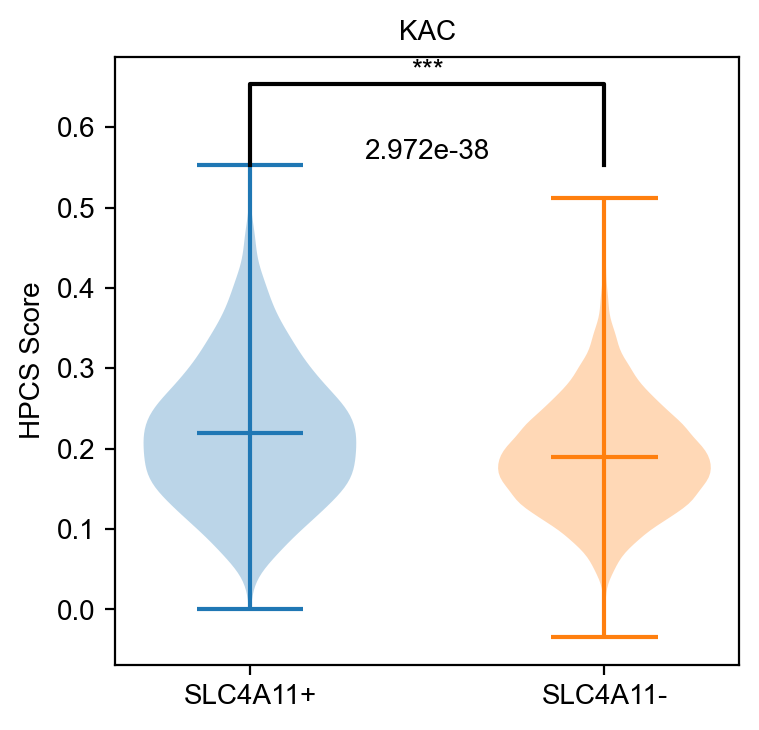

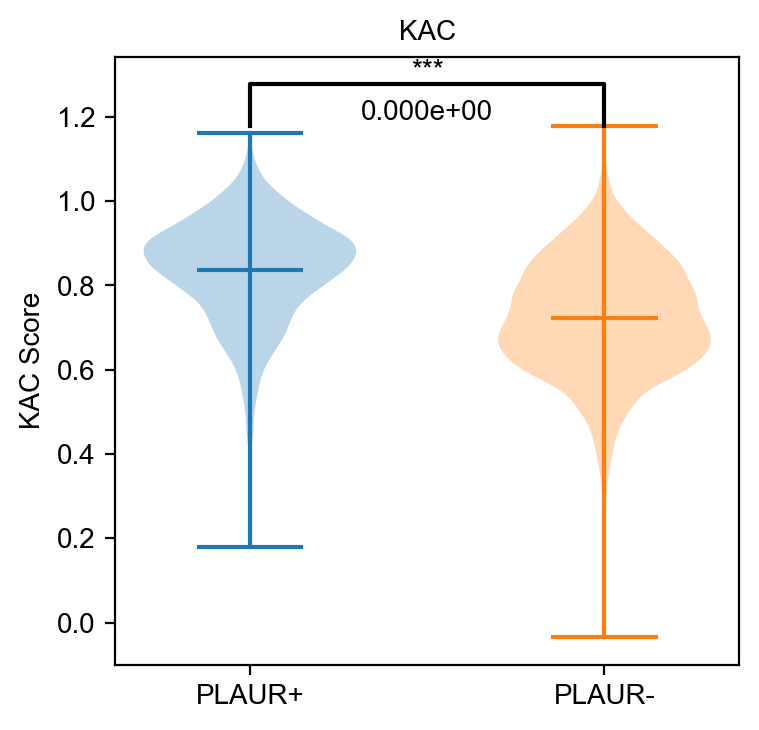

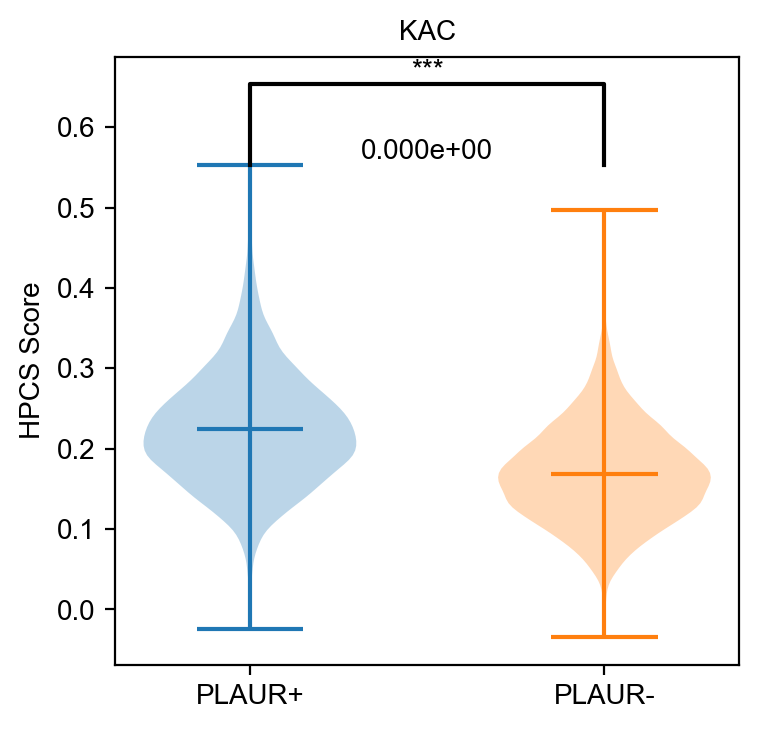

In [34]:
from scipy import stats

sc.tl.score_genes(adata, hpcs, score_name="HPCS")
sc.tl.score_genes(adata, kac, score_name="KAC")
key="KAC"
outDir = "DTAPlungMouse"
plotScatter(adata.obs, "HPCS", "KAC", key,save=outDir)
rdata = adata.raw.to_adata()
slc="SLC4A11"
if(isinstance(rdata.X, np.ndarray)):
    slcScore = np.array(rdata[:,rdata.var_names==slc].X).flatten() > 0
    plaScore = np.array(rdata[:,rdata.var_names=="PLAUR"].X).flatten() > 0
else:
    slcScore = np.array(rdata[:,rdata.var_names==slc].X.todense()).flatten() > 0
    plaScore = np.array(rdata[:,rdata.var_names=="PLAUR"].X.todense()).flatten() > 0

plotBoxPlot(adata.obs, "KAC", slcScore, "SLC4A11", key,save=outDir)
plotBoxPlot(adata.obs, "HPCS", slcScore, "SLC4A11",key,save=outDir)

plotBoxPlot(adata.obs, "KAC", plaScore, "PLAUR",key,save=outDir)
plotBoxPlot(adata.obs, "HPCS", plaScore, "PLAUR",key,save=outDir)

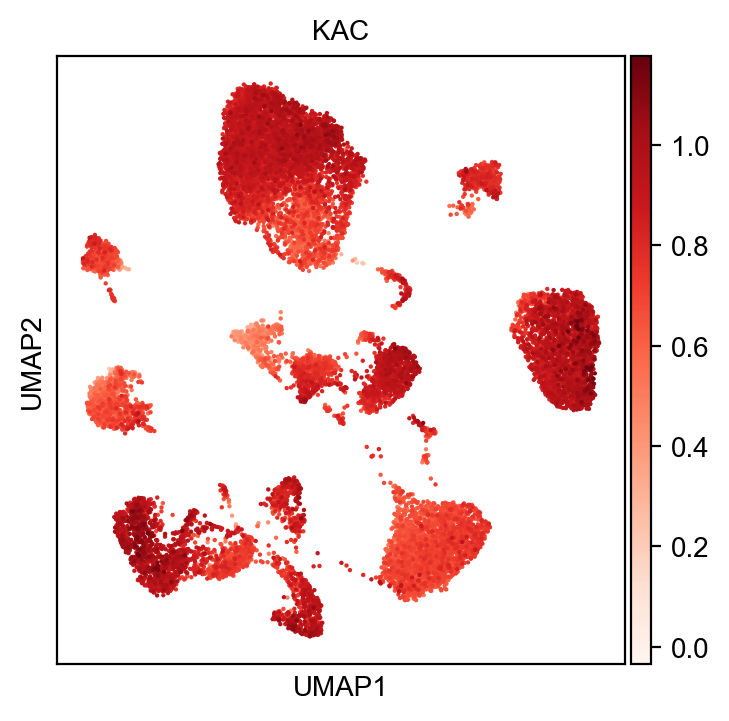

In [38]:
fileName = "umap_kac_KAC"
sc.pl.umap(adata, color=["KAC"],cmap="Reds",size=10,save=f"Fig5_{fileName}.svg")

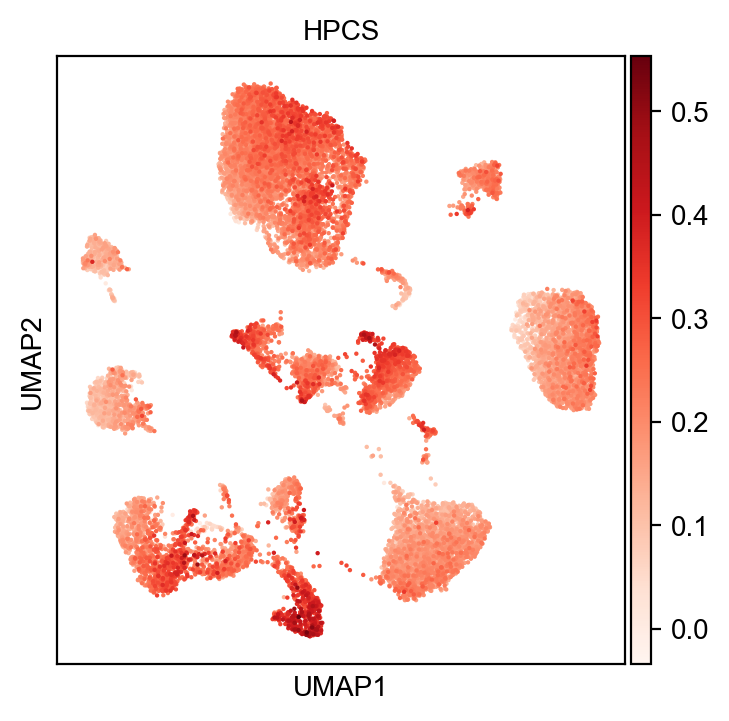

In [39]:
fileName = "umap_kac_HPCS"
sc.pl.umap(adata, color=["HPCS"],cmap="Reds",size=10,save=f"Fig5_{fileName}.svg")

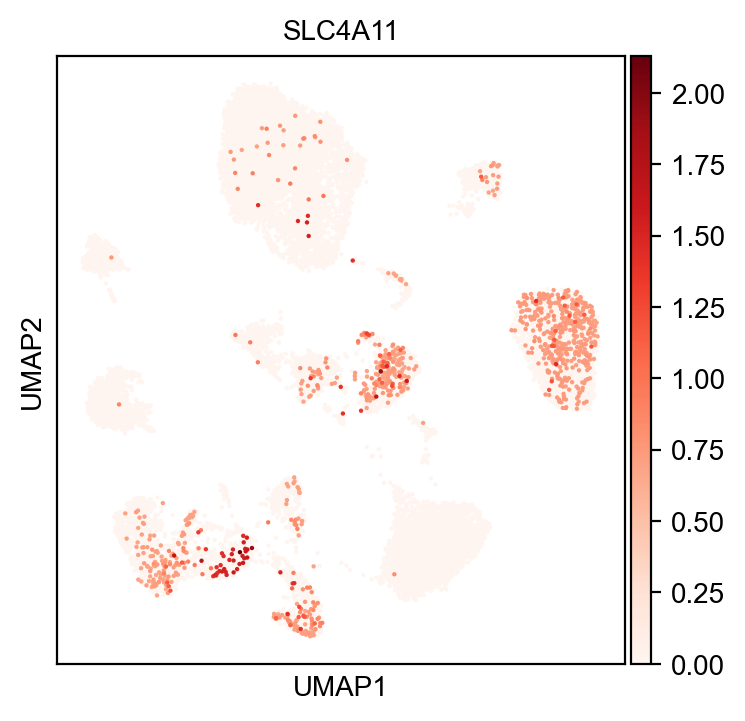

In [40]:
fileName = "umap_kac_SLC4A11"
sc.pl.umap(adata, color=["SLC4A11"],cmap="Reds",size=10,save=f"Fig5_{fileName}.svg")

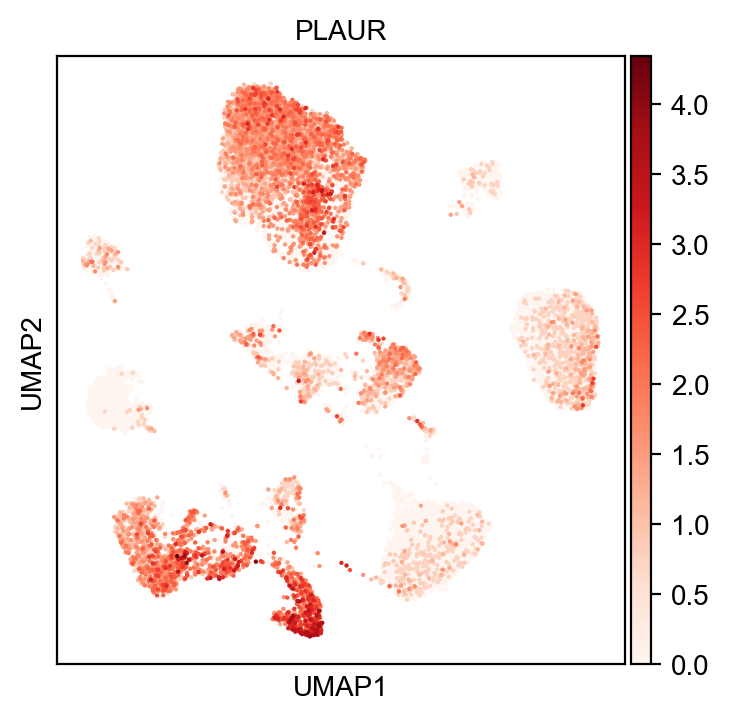

In [41]:
fileName = "umap_kac_PLAUR"
sc.pl.umap(adata, color=["PLAUR"],cmap="Reds",size=10,save=f"Fig5_{fileName}.svg")